In [2]:
#load packages
import os, sys, cv2, re, itertools
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from PyQt5 import QtWidgets, QtGui
from PyQt5.uic import loadUi
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [3]:
from customised_functions import * #import my customised functions

In [4]:
#Stage I: test a simple CNN model with regression output.

#Data preparation
##load dataframe prepared 
train_folder = "C:/Users/folia/metar_project/images/filtered/filtered_train_cropped"
df = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_train_cropped/filtered_train.xlsx")
df = df.sample(frac=1) #random shuffle for dataframe, just to cut off smilarities between "windows" and let model learn more complex patterns

vali_pct = 0.8
vali_cut = int(len(df)*vali_pct)

##divide into training and validation parts
df_train = df[0:vali_cut]
df_vali = df[vali_cut:]
vali_steps = len(df_vali)

##training data generator-to preprocess images on the fly, which saves memory space
train_gen_spec = image.ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip=True,
                                  vertical_flip=True)
train_generator = train_gen_spec.flow_from_dataframe(dataframe = df_train,
                                                         directory = train_folder,
                                                         x_col = "window_name",
                                                         y_col = "cloud_height",
                                                         target_size = (149,99),
                                                         batch_size = 16,
                                                         class_mode = "other")


#Validation generator
vali_gen_spec = image.ImageDataGenerator(rescale = 1./255)
vali_generator = vali_gen_spec.flow_from_dataframe(dataframe = df_vali,
                                                         directory = train_folder,
                                                         x_col = "window_name",
                                                         y_col = "cloud_height",
                                                         target_size = (149,99),
                                                         batch_size = 16,
                                                         class_mode = "other")

Found 272 validated image filenames.
Found 68 validated image filenames.


In [5]:
#build neural network
##build convnet for only one input (photos) regression using functional API 
inputs = keras.Input(shape=(149,99,3),name = "window_input")
hidden_layers = layers.Conv2D(filters = 32, kernel_size = 5, activation = "relu")(inputs)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Conv2D(filters = 64, kernel_size = 5, activation = "relu")(hidden_layers)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
hidden_layers = layers.Dense(256,activation = "relu")(hidden_layers)
outputs = layers.Dense(1,activation = "linear")(hidden_layers) #for regression purpose, adapt "linear" activation method

model1 = keras.Model(inputs = inputs, outputs = outputs)
model1.summary()
model1.compile(loss = "mean_squared_error", optimizer = "adam")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 window_input (InputLayer)   [(None, 149, 99, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 145, 95, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 27, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 9, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8064)              0     

In [7]:
#fit the data into model
history1 = model1.fit(x= train_generator, epochs=8, verbose=1, validation_data = vali_generator)

Epoch 1/8
17/17 [==============================] - 1s 54ms/step - loss: 3171.0938 - val_loss: 4194.9751
Epoch 2/8
17/17 [==============================] - 1s 49ms/step - loss: 3010.7200 - val_loss: 3684.3621
Epoch 3/8
17/17 [==============================] - 1s 50ms/step - loss: 2993.5085 - val_loss: 3616.3013
Epoch 4/8
17/17 [==============================] - 1s 45ms/step - loss: 3116.5710 - val_loss: 3929.4160
Epoch 5/8
17/17 [==============================] - 1s 49ms/step - loss: 3015.5264 - val_loss: 4129.0762
Epoch 6/8
17/17 [==============================] - 1s 49ms/step - loss: 2844.5190 - val_loss: 3625.1309
Epoch 7/8
17/17 [==============================] - 1s 48ms/step - loss: 2785.5342 - val_loss: 4183.3950
Epoch 8/8
17/17 [==============================] - 1s 47ms/step - loss: 2851.1897 - val_loss: 4294.8198


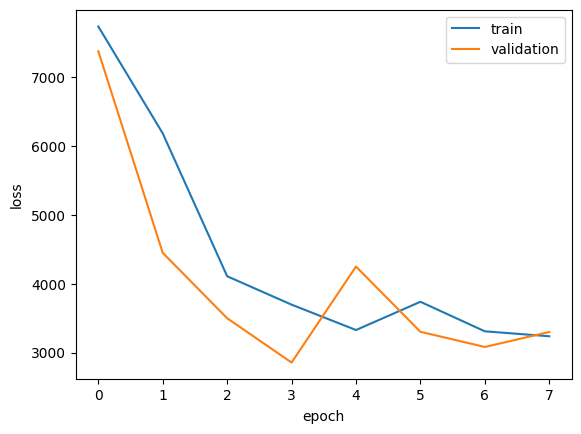

In [6]:
#Visualise regression history
regression_history_plot(history1)

In [8]:
#evaluate the regression model
df_test = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_test_cropped/filtered_test.xlsx")
test_folder = "C:/Users/folia/metar_project/images/filtered/filtered_test_cropped"


##prepare test data generator
test_gen_spec = image.ImageDataGenerator(rescale=1./255)

test_generator = test_gen_spec.flow_from_dataframe(dataframe=df_test,
                                                  directory = test_folder,
                                                  x_col="window_name",
                                                  target_size=(149,99),
                                                  batch_size=1,
                                                  class_mode= None)
test_generator.reset() #reset the generator before putting in, make sure the memory is clear

#make predictions using model trained
pred = model1.predict(x=test_generator, steps = len(df_test)) #return a 1D array consist of predicted values
cloud_height_pred = pred.flatten().astype(int) #remove fractions

#write the predicted values into a csv file
df_pred_result = pd.DataFrame({"window_name":df_test['window_name'], "y_pred":cloud_height_pred, "y_true":df_test["cloud_height"]})
df_pred_result.to_csv(os.path.join(test_folder,"predicts.csv"))

Found 178 validated image filenames.
178/178 [==============================] - 0s 2ms/step


The Mean square error of model 1 is 7231.854
Check the 10 largest error are                          window_name  y_pred  y_true  pred_error
6                     1228N_0_6.jpg      56     200         144
47          1305-HDR_normal_2_7.jpg      56     200         144
21                    1228N_2_5.jpg      57     200         143
51          1310-HDR_normal_0_3.jpg      57     200         143
58          1310-HDR_normal_1_2.jpg      57     200         143
63          1310-HDR_normal_1_7.jpg      57     200         143
92         20231120-154755N_0_0.jpg      57     200         143
103        20231120-154755N_1_3.jpg      57     200         143
120        20231123-141622N_2_1.jpg      57     200         143
126  20231123-141850_normal_1_1.jpg      57     200         143


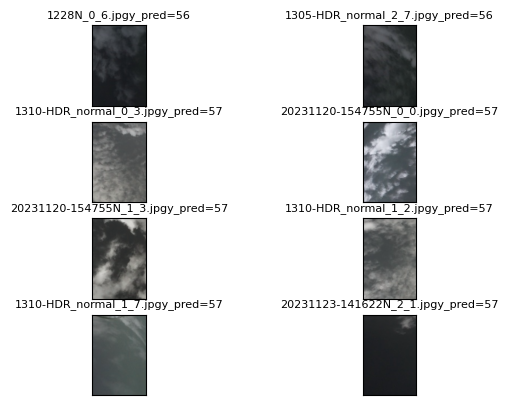

'\nMSE = 7265 (error closes to 85, not acceptable)\n\nInterfrence:\n1.High exposure area: high exposure area may leads to a "flatten" texture, which is similar to bright sky.\n2.Edge of cloud: some small parts of cloud may be recognised as high clouds such as Cirrocumulus. Also, it may be my clissification error.\n3.Human classification and mearsuring error.\n4.Limited data doesn\'t provide enough information of patterns.\n5.Shuffling Data decrease MSE from around 9000 to 7179. this refers to that the model is able to learn new patterns.\n'

In [9]:
#Examinate the first result
'''
Checking the training history plot, the decresing of loss seems to hit a limit after the 3 epoch, below is to
check the Mean Square Error of the first model.
'''

#1. calculate MSE
model1_mse = np.square(np.subtract(df_pred_result['y_true'],df_pred_result['y_pred'])).mean() #MSE = (1/n)*Sigma(y_true-y_pred)^2
print(f'The Mean square error of model 1 is {round(model1_mse,3)}')

#2. check 10 images of largest prediction error
df_pred_result['pred_error'] = np.subtract(df_pred_result['y_true'],df_pred_result['y_pred']).abs()
print("Check the 10 largest error are ",df_pred_result.nlargest(10,'pred_error'))

#check photos
df_pred_result.sort_values("pred_error",axis = 0, ascending =False, inplace =True)
df_pred_result['window_name'][1:10]


index = df_pred_result.index
for i in range(8):
    j = index[i] #a short handed variable for shuffled index
    img = cv2.imread(os.path.join(test_folder,df_pred_result['window_name'][j]))
    plt.subplot(4,2,i+1)
    plt.imshow(img)
    plt.title(df_pred_result['window_name'][j] + "y_pred="+str(df_pred_result['y_pred'][j]),fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.show()

'''
MSE = 7231 (error closes to 85, not acceptable)

Inference:
1.High exposure area: high exposure area may leads to a "flatten" texture, which is similar to bright sky.
2.Edge of cloud: some small parts of cloud may be recognised as high clouds such as Cirrocumulus. Also, it may be my clissification error.
3.Human classification and mearsuring error.
4.Limited data doesn't provide enough information of patterns.
5.Shuffling Data decrease MSE from around 9000 to 7179. this refers to that the model is able to learn new patterns.
'''